In [12]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install pyLDAvis
!pwd

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
/content


In [14]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


In [15]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [16]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [17]:
df.head(2)

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...


In [18]:
!pip install contractions

In [19]:

# import nltk
# nltk.download('punkt_tab')
!pip install -U spacy
#torch transformers

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 re

In [20]:
df.shape[0]

87034

In [21]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [22]:
# ## Data cleaning
# import re, string
# import pandas as pd
# import contractions
# from collections import Counter
# import nltk
# from nltk.corpus     import stopwords
# from nltk.tokenize   import word_tokenize
# from nltk.stem       import WordNetLemmatizer




# #  Convert any timestamp column now if you’ll need it:
# df['created_utc'] = pd.to_datetime(df['created_utc'])

# # Define your full-clean function once
# nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def full_clean(doc):
#     doc = re.sub(r'\s+', ' ', doc).strip()
#     doc = doc.lower()
#     doc = re.sub(r'http\S+|www\.\S+', '', doc)
#     doc = re.sub(r'<.*?>',          '', doc)
#     doc = re.sub(r'@\w+|#\w+',      '', doc)
#     doc = contractions.fix(doc)
#     doc = doc.translate(str.maketrans('', '', string.punctuation))
#     doc = re.sub(r'\d+', '', doc)
#     tokens = [
#         lemmatizer.lemmatize(t)
#         for t in word_tokenize(doc)
#         if t not in stop_words and len(t)>2
#     ]
#     return tokens

# #  Apply it once to every row
# df['tokens']     = df['cleaned_text'].apply(full_clean)
# df['final_text'] = df['tokens'].str.join(' ')


# df[['created_utc','score','final_text','tokens']].head()
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()



,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [23]:
df.shape[0]

86446

In [ ]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'high pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
start_date = '2022-11-01'
end_date = '2023-01-31'

# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

In [ ]:
high_pos_df.shape[0]

       token  count
0       good    755
1      thank    624
2     flight    524
3      great    507
4      point    362
5       book    333
6       like    297
7       time    294
8        fly    291
9       look    287
10      trip    266
11      nice    238
12      find    225
13      well    213
14   airline    208
15       get    200
16       day    195
17       way    194
18    travel    182
19  business    179
20     think    174
21      know    170
22    pretty    169
23        go    168
24      year    167
25      seat    166
26     hotel    158
27      love    151
28     class    149
29     check    140


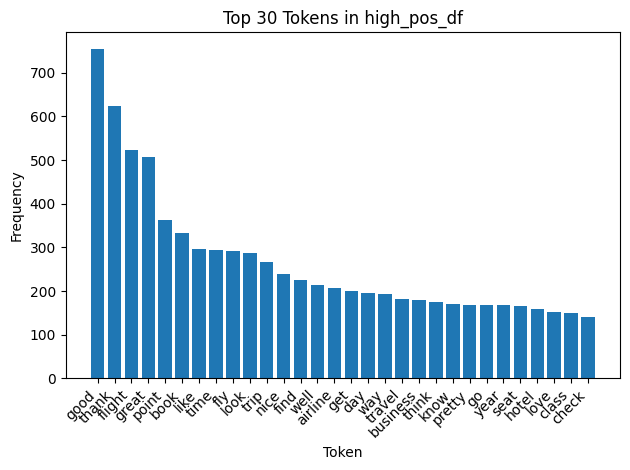

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


36308 words total, with a vocabulary size of 4940
Max reddit post length is 222 tokens
Mean reddit post length is 14.94 tokens
Median reddit post length is 10 tokens


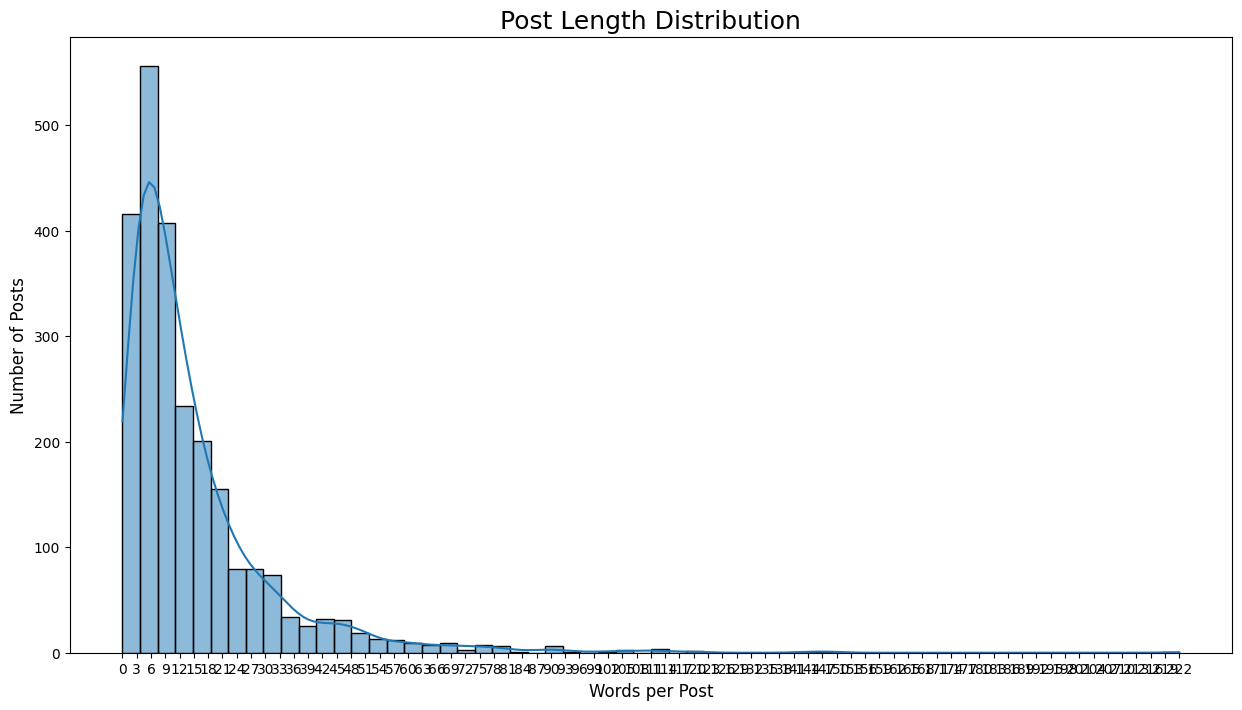

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5)
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
63022  [lol, whelp, hopefully, plan, flexible, find, ...   
63031                                   [helpful, thank]   
63045  [appreciate, help, definitely, lean, wait, day...   
63049          [sound, nice, def, lean, thompson, thank]   
63059                                       [good, deal]   

                                           bigram_tokens  \
63022  [lol, whelp, hopefully, plan, flexible, find, ...   
63031                                   [helpful, thank]   
63045  [appreciate, help, definitely, lean, wait, day...   
63049          [sound, nice, def, lean, thompson, thank]   
63059                                       [good, deal]   

                                          trigram_tokens  
63022  [lol, whelp, hopefully, plan, flexible, find, ...  
63031                                   [helpful, thank]  
63045  [appreciate, help, definitely, lean, wait, day...  
63049          [sound, nice, def, lean, th

In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   517
Rows with trigrams:  3
Rows with no n-grams: 1913


In [ ]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
63022,2023-01-02,high pos,0.862796,lol whelp hopefully plan flexible find availab...,"[lol, whelp, hopefully, plan, flexible, find, ...",lol whelp hopefully plan flexible find availab...,"[lol, whelp, hopefully, plan, flexible, find, ...","[lol, whelp, hopefully, plan, flexible, find, ...",False,False
63031,2023-01-02,high pos,0.970024,really helpful thanks,"[helpful, thank]",helpful thank,"[helpful, thank]","[helpful, thank]",False,False
63045,2023-01-02,high pos,0.831712,appreciate help definitely leaning towards wai...,"[appreciate, help, definitely, lean, wait, day...",appreciate help definitely lean wait day open ...,"[appreciate, help, definitely, lean, wait, day...","[appreciate, help, definitely, lean, wait, day...",False,False
63049,2023-01-02,high pos,0.921123,sound nice def leaning thompson thx,"[sound, nice, def, lean, thompson, thank]",sound nice def lean thompson thank,"[sound, nice, def, lean, thompson, thank]","[sound, nice, def, lean, thompson, thank]",False,False
63059,2023-01-02,high pos,0.846220,good deal,"[good, deal]",good deal,"[good, deal]","[good, deal]",False,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 2430
Number of rows in 'trigram_tokenized' column: 2430


In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# 2)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 1

Most common trigrams:
star_alliance_partner: 4


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=100,
#                                         iterations=100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:

## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

#
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence,alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50,  100, 200]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f},Alpha:{alpha}, Eta:{eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']


print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.2163, Coherence: 0.5950,Alpha:[0.5791183  0.08003344], Eta:[1.297248   0.38858178 2.4060857  ... 0.4325431  0.41656432 0.41656652]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.2312, Coherence: 0.5567,Alpha:[0.78422695 0.07037953], Eta:[1.2518269  0.390511   1.8835136  ... 0.43077543 0.41876867 0.41877076]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.2815, Coherence: 0.5344,Alpha:[1.0122148 0.2136292], Eta:[1.1406313  0.36983937 1.8096293  ... 0.39786813 0.40243673 0.41433087]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.1940, Coherence: 0.5739,Alpha:[0.3680313 0.0627576], Eta:[1.4012582  0.4055929  7.995718   ... 0.44668955 0.43235192 0.43235356]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.2002, Coherence: 0.5682,Alpha:[0.4112104  0.04632873], Eta:[1.3567195  0.4102566  2.3493586  ... 0.44743776 0.43758255 0.4375839 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.2695, Coherence: 0.5027,Alpha:[0.9344434  0.19189294], Eta:[1.1647787  0.3786974  1.8533094  ... 0.40420327 0.40829018 0.41916287]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.1804, Coherence: 0.5852,Alpha:[0.24656445 0.04865854], Eta:[ 1.479676    0.4163541  13.998523   ...  0.45580542  0.44246396
  0.442465  ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.1864, Coherence: 0.5706,Alpha:[0.26224977 0.03497717], Eta:[1.412631   0.42132905 3.4308348  ... 0.45644578 0.4480083  0.44800925]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.2595, Coherence: 0.4879,Alpha:[0.8121096  0.16845891], Eta:[1.1916975  0.38693005 1.9500045  ... 0.41117394 0.4139652  0.42396635]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.2852, Coherence: 0.5755,Alpha:[1.2479485  0.14708439 0.1291909 ], Eta:[0.4438586  0.2697763  0.5200427  ... 0.27461478 0.27461234 0.27460626]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.2868, Coherence: 0.5809,Alpha:[1.2988809  0.14818604 0.12835562], Eta:[0.44728482 0.26983872 0.5240119  ... 0.275895   0.27589217 0.27588487]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.2937, Coherence: 0.5790,Alpha:[1.3971181  0.19009584 0.13038126], Eta:[0.4451579  0.2704911  0.51938885 ... 0.27479258 0.27478114 0.27474454]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.2702, Coherence: 0.5707,Alpha:[1.107205   0.13095541 0.11693283], Et

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.2169, Coherence: 0.5777,Alpha:[0.07790377 0.5748938 ], Eta:[1.2812022  0.38915795 2.4352784  ... 0.4317761  0.41721764 0.4172198 ]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.2166, Coherence: 0.5777,Alpha:[0.07356423 0.5688749 ], Eta:[1.2858192  0.39053997 2.3630002  ... 0.43252435 0.4187847  0.41878682]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.2166, Coherence: 0.5777,Alpha:[0.07292096 0.5681969 ], Eta:[1.2863889  0.3906708  2.342167   ... 0.43254048 0.41893318 0.4189353 ]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.1957, Coherence: 0.5747,Alpha:[0.06355471 0.38246724], Eta:[1.3736856  0.40458906 7.9427414  ... 0.44468078 0.43122905 0.43123075]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.1948, Coherence: 0.5893,Alpha:[0.05807631 0.3665831 ], Eta:[1.3797352  0.40632728 6.495126   ... 0.4459146  0.43317518 0.43317673]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.1950, Coherence: 0.5893,Alpha:[0.05758436 0.366984  ], Eta:[1.3794515  0.40638584 6.1323466  ... 0.44584584 0.433241   0.43324256]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.1818, Coherence: 0.5738,Alpha:[0.04993081 0.25492164], Eta:[ 1.460295    0.41508865 13.897453   ...  0.45368385  0.44105634
  0.4410575 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.1804, Coherence: 0.5889,Alpha:[0.04548318 0.24251194], Eta:[ 1.4706059   0.41732103 13.912105   ...  0.45566332  0.4435404
  0.44354147]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.1801, Coherence: 0.5889,Alpha:[0.04477867 0.2390818 ], Eta:[ 1.4724995  0.4176002 13.955212  ...  0.4559257  0.443851   0.4438522]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.3023, Coherence: 0.5067,Alpha:[0.10606085 1.151656   0.25591972], Eta:[0.43997556 0.26365727 0.5232104  ... 0.27495685 0.27608004 0.27787194]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.3141, Coherence: 0.4580,Alpha:[0.0981815  1.4122214  0.28464973], Eta:[0.45415923 0.2681987  0.5306381  ... 0.28006226 0.28121814 0.28363755]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.3179, Coherence: 0.4868,Alpha:[0.10951439 1.5716577  0.30932423], Eta:[0.45257565 0.26768735 0.5266983  ... 0.27967834 0.28250575 0.28561345]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.2752, Coherence: 0.5544,Alpha:[0.08907398 0.9076299  0.21143107], Et

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.2152, Coherence: 0.5936,Alpha:[0.08142618 0.57588387], Eta:[1.2846465  0.38824826 2.4771163  ... 0.4316438  0.41618308 0.41618523]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.2151, Coherence: 0.5936,Alpha:[0.08039179 0.580984  ], Eta:[1.2852039  0.38830766 2.4764109  ... 0.43164864 0.4162495  0.4162518 ]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.2153, Coherence: 0.5936,Alpha:[0.08047812 0.5859728 ], Eta:[1.2841876  0.3881808  2.458277   ... 0.43153298 0.41610605 0.41610828]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.1929, Coherence: 0.5885,Alpha:[0.05950787 0.3435625 ], Eta:[1.3884581  0.4056572  9.15898    ... 0.44580114 0.43242326 0.43242484]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.1924, Coherence: 0.5885,Alpha:[0.05801407 0.3389585 ], Eta:[1.3914231  0.40600553 9.22925    ... 0.446122   0.4328129  0.4328144 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.1925, Coherence: 0.5885,Alpha:[0.05814819 0.34301674], Eta:[1.3913908  0.405978   9.201624   ... 0.44610044 0.432782   0.4327836 ]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.1797, Coherence: 0.5821,Alpha:[0.0460416  0.23894079], Eta:[ 1.4661627   0.41628075 14.239648   ...  0.45442984  0.4423831
  0.44238418]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.1797, Coherence: 0.5821,Alpha:[0.04572324 0.23894072], Eta:[ 1.4654282   0.416318   14.251187   ...  0.45454082  0.4424245
  0.44242567]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.1793, Coherence: 0.5821,Alpha:[0.04484022 0.23622571], Eta:[ 1.4680722   0.41657454 14.261005   ...  0.45474982  0.44270992
  0.442711  ]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.3014, Coherence: 0.4587,Alpha:[0.11602377 0.27650574 1.6269774 ], Eta:[0.44000396 0.26324895 0.517822   ... 0.27744004 0.27397844 0.27382037]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.2908, Coherence: 0.5822,Alpha:[0.14815904 0.12524235 1.4452821 ], Eta:[0.44751206 0.27446368 0.5221235  ... 0.28231394 0.28527236 0.27723512]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.2916, Coherence: 0.5492,Alpha:[0.12196382 0.1688559  1.5240211 ], Eta:[0.44988793 0.27756375 0.52525187 ... 0.27995268 0.2780504  0.278038  ]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.2789, Coherence: 0.4699,Alpha:[0.08457709 0.20017183 1.314978

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5950
 Perplexity: -7.2163
 Alpha (per topic): [0.5791183  0.08003344]
 Eta   (per word):  [1.297248   0.38858178 2.4060857  ... 0.4325431  0.41656432 0.41656652]


In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
# : Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.025*"good" + 0.023*"thank" + 0.019*"flight" + 0.012*"great" + '
  '0.010*"book" + 0.010*"point" + 0.009*"fly" + 0.008*"time" + 0.008*"airline" '
  '+ 0.007*"look"'),
 (1,
  '0.011*"stay" + 0.010*"hotel" + 0.009*"great" + 0.008*"room" + 0.008*"nice" '
  '+ 0.007*"time" + 0.006*"night" + 0.006*"hyatt" + 0.006*"like" + '
  '0.005*"food"')]

Sample doc-topic distribution for doc 0:
[(0, 0.99247724)]


In [ ]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:

print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  good (0.0252)
  thank (0.0225)
  flight (0.0189)
  great (0.0124)
  book (0.0103)
  point (0.0100)
  fly (0.0091)
  time (0.0081)
  airline (0.0080)
  look (0.0075)
  find (0.0068)
  like (0.0068)
  trip (0.0068)
  travel (0.0066)
  get (0.0062)
  way (0.0061)
  well (0.0061)
  know (0.0051)
  seat (0.0050)
  day (0.0049)
  pretty (0.0048)
  nice (0.0047)
  work (0.0047)
  go (0.0047)
  check (0.0046)
  think (0.0043)
  year (0.0042)
  help (0.0040)
  love (0.0040)
  try (0.0038)

Topic 2:
  stay (0.0109)
  hotel (0.0104)
  great (0.0094)
  room (0.0082)
  nice (0.0079)
  time (0.0067)
  night (0.0064)
  hyatt (0.0064)
  like (0.0057)
  food (0.0051)
  property (0.0044)
  day (0.0043)
  walk (0.0040)
  place (0.0039)
  lot (0.0038)
  airport (0.0038)
  think (0.0036)
  area (0.0035)
  city (0.0034)
  beautiful (0.0033)
  kyoto (0.0033)
  beach (0.0032)
  kid (0.0030)
  location (0.0030)
  amazing (0.0030)
  want (0.0030)
  well (0.0029)
  anda

In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_pos_4th_wave_normal.gensim')

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

## pruning
id2word.filter_extremes(no_below=5, no_above=0.8)

#    (Optional) Re-map the remaining token IDs to remove gaps
id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_pos_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [ ]:

## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence,alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50,  100, 200]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f},Alpha:{alpha}, Eta:{eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.3150, Coherence: 0.5360,Alpha:[1.778153  0.8887229], Eta:[1.0353869  3.3808062  0.4760094  ... 0.39158598 0.3465505  0.41753358]
Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.3218, Coherence: 0.5216,Alpha:[1.7837384 1.033055 ], Eta:[1.6883371  5.982895   0.50397646 ... 0.4237668  0.3452865  0.3742854 ]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.3252, Coherence: 0.4724,Alpha:[1.7008098 1.1411421], Eta:[0.6659343  5.1609693  0.75648195 ... 0.57463384 0.35241368 0.3667004 ]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.2989, Coherence: 0.5611,Alpha:[1.6698258 0.6104444], Eta:[0.676782   1.2715068  0.48156434 ... 0.37337193 0.35788602 0.48723528]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.3123, Coherence: 0.5177,Alpha:[1.6414598 0.8933067], Eta:[1.9221607  4.3394785  0.48325762 ... 0.38733023 0.34604403 0.3920993 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.3199, Coherence: 0.4818,Alpha:[1.5175017 1.1267927], Eta:[0.65265226 3.128788   1.1359907  ... 0.58377784 0.35302147 0.3646326 ]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.2832, Coherence: 0.5752,Alpha:[0.8581886  0.18841805], Eta:[0.7114001  1.4372935  0.5128116  ... 0.39450225 0.37031364 0.67111933]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.2980, Coherence: 0.5470,Alpha:[1.6135993 0.5963766], Eta:[0.68800515 1.42114    0.4827665  ... 0.3734543  0.3568508  0.4570709 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.3127, Coherence: 0.4674,Alpha:[1.4070046 1.0930538], Eta:[0.6352279  1.1387297  0.99341863 ... 0.5788307  0.3593654  0.36851883]


Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.3229, Coherence: 0.4915,Alpha:[1.7617539 0.4409127 1.5379946], Eta:[0.27912658 0.31788963 0.2585973  ... 0.22824413 0.22344209 0.23554341]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.3252, Coherence: 0.5285,Alpha:[2.088203   0.37357917 1.5212276 ], Eta:[0.2804152  0.31947437 0.25920486 ... 0.22837132 0.2332093  0.22958192]


Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.3285, Coherence: 0.5142,Alpha:[2.233458   0.37809744 1.5935434 ], Eta:[0.27986547 0.31940764 0.25910386 ... 0.22895768 0.22569828 0.2300905 ]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.3156, Coherence: 0.5040,Alpha:[1.6311113 0.4074398 1.4311806], Eta:[0.27975377 0.3187921  0.2595449  ... 0.22895686 0.22334588 0.23114477]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.3160, Coherence: 0.5443,Alpha:[1.8624942 0.3346868 1.3713388], Eta:[0.28035256 0.31982085 0.2603815  ... 0.22854193 0.23396449 0.22859503]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.3177, Coherence: 0.5333,Alpha:[1.970154   0.32736754 1.375694  ], Eta:[0.27905935 0.31903446 0.25921962 ... 0.22776039 0.22306676 0.22738987]
Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.3115, Coherence: 0.5160,Alpha:[1.5206457  0.38655493 1.3561454 ], Eta:[0.279625   0.3195306  0.260374   ... 0.23040326 0.22308198 0.22993629]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.3114, Coherence: 0.5463,Alpha:[1.7242243 0.3117526 1.28145  ], Eta:[0.2806203  0.3206079  0.26144806 ... 0.22991772 0.23215333 0.22802499]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.3121, Coherence: 0.5292,Alpha:[1.7773966  0.30009732 1.279999  ], Eta:[0.27972418 0.32027856 0.26114416 ... 0.22879028 0.2231341  0.22753976]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.3831, Coherence: 0.4776,Alpha:[2.5520902 0.6769755 3.4501367 2.3108094], Eta:[0.19849081 0.20862088 0.18723224 ... 0.17882381 0.17354858 0.18032098]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.3861, Coherence: 0.4921,Alpha:[2.7611806  0.78747135 2.9585962  2.9984794 ], Eta:[0.19756132 0.207555   0.18583402 ... 0.17775649 0.1737374  0.17977607]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.3921, Coherence: 0.4851,Alpha:[3.6925323 1.2916356 1.9261959 3.7840617], Eta:[0.19565383 0.20506287 0.18583521 ... 0.1775496  0.17444846 0.17816272]
Num Topics: 4, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.3781, Coherence: 0.4976,Alpha:[2

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5752
 Perplexity: -6.2832
 Alpha (per topic): [0.8581886  0.18841805]
 Eta   (per word):  [0.7114001  1.4372935  0.5128116  ... 0.39450225 0.37031364 0.67111933]


In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.033*"good" + 0.030*"thank" + 0.025*"flight" + 0.016*"great" + '
  '0.014*"book" + 0.012*"fly" + 0.012*"point" + 0.010*"look" + 0.010*"airline" '
  '+ 0.010*"find"'),
 (1,
  '0.019*"hotel" + 0.015*"great" + 0.015*"stay" + 0.015*"nice" + 0.015*"night" '
  '+ 0.012*"time" + 0.011*"room" + 0.011*"like" + 0.010*"place" + '
  '0.010*"service"')]

Sample doc-topic distribution for doc 0:
[(0, 0.9765532), (1, 0.0234468)]


In [ ]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  good (0.0330)
  thank (0.0298)
  flight (0.0251)
  great (0.0165)
  book (0.0141)
  fly (0.0124)
  point (0.0122)
  look (0.0103)
  airline (0.0103)
  find (0.0098)
  time (0.0095)
  trip (0.0088)
  like (0.0083)
  travel (0.0079)
  way (0.0079)
  get (0.0076)
  well (0.0074)
  seat (0.0071)
  know (0.0068)
  work (0.0064)
  day (0.0063)
  pretty (0.0063)
  check (0.0061)
  go (0.0058)
  help (0.0054)
  think (0.0051)
  awesome (0.0051)
  nice (0.0050)
  love (0.0049)
  try (0.0049)

Topic 2:
  hotel (0.0188)
  great (0.0154)
  stay (0.0149)
  nice (0.0148)
  night (0.0146)
  time (0.0121)
  room (0.0113)
  like (0.0105)
  place (0.0104)
  service (0.0102)
  hyatt (0.0099)
  food (0.0097)
  lounge (0.0086)
  spend (0.0078)
  point (0.0077)
  think (0.0072)
  day (0.0067)
  free (0.0066)
  city (0.0065)
  well (0.0064)
  property (0.0062)
  lot (0.0062)
  tokyo (0.0061)
  want (0.0059)
  good (0.0058)
  love (0.0056)
  absolutely (0.0056)
  exp

In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_pos_4th_wave_pruned.gensim')

In [ ]:
# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'high neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
start_date = '2022-11-01'
end_date = '2023-01-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-49-bd3168c675b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
63086,2023-01-02,high neg,0.834160,mean pringles economy really insist slumming,"[mean, pringle, economy, insist, slum]",mean pringle economy insist slum
63103,2023-01-01,high neg,0.836027,service good right need change flight select s...,"[service, good, right, need, change, flight, s...",service good right need change flight select s...
63112,2023-01-01,high neg,0.878878,ac suck,[suck],suck
63114,2023-01-01,high neg,0.941867,legit behind post flew air canada pe yesterday...,"[legit, post, fly, air, canada, yesterday, fco...",legit post fly air canada yesterday fcoyul sna...
63185,2023-01-01,high neg,0.887383,linked comment bad reddit sorry,"[link, comment, bad, reddit, sorry]",link comment bad reddit sorry


In [ ]:
high_neg_first_wave_df.shape[0]

1175

       token  count
0     flight    325
1    airline    183
2       like    180
3       time    141
4        bad    137
5        fly    135
6     people    115
7      point    103
8        get     98
9       book     97
10      work     92
11       try     86
12      know     84
13    ticket     83
14        go     78
15    cancel     75
16   airport     74
17   service     71
18      seat     71
19       day     71
20      hour     68
21       pay     68
22      suck     67
23     think     67
24      find     65
25       say     65
26  customer     64
27    travel     64
28      shit     60
29      look     60


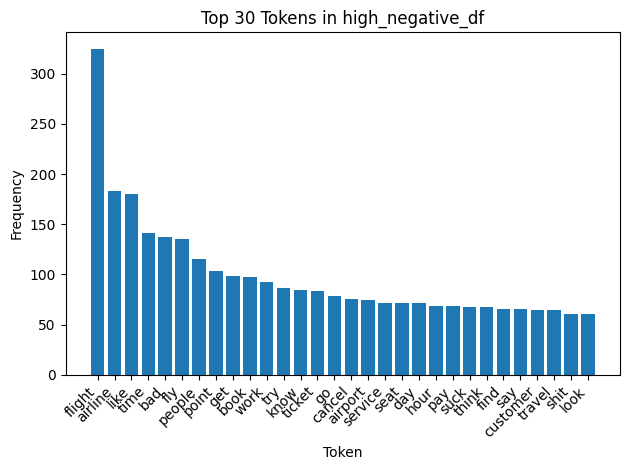

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


15904 words total, with a vocabulary size of 3350
Max reddit post length is 171 tokens
Mean reddit post length is 13.54 tokens
Median reddit post length is 9 tokens


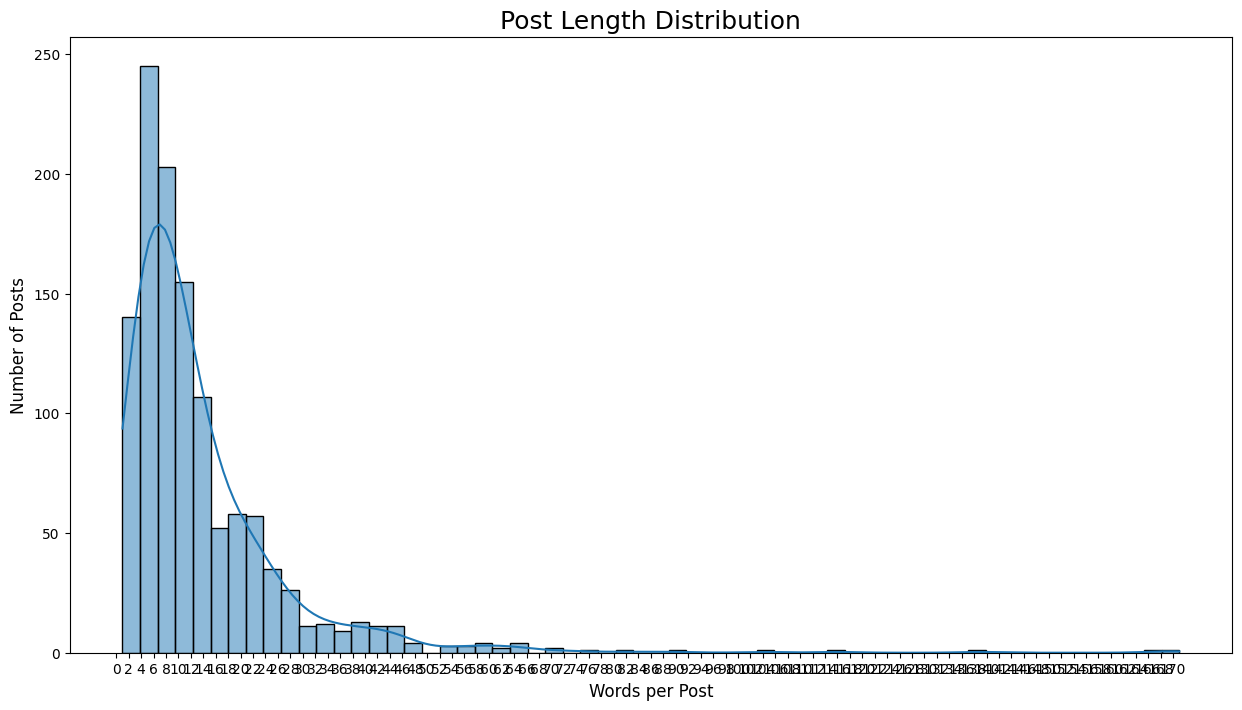

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
63086             [mean, pringle, economy, insist, slum]   
63103  [service, good, right, need, change, flight, s...   
63112                                             [suck]   
63114  [legit, post, fly, air, canada, yesterday, fco...   
63185                [link, comment, bad, reddit, sorry]   

                                           bigram_tokens  \
63086             [mean, pringle, economy, insist, slum]   
63103  [service, good, right, need, change, flight, s...   
63112                                             [suck]   
63114  [legit, post, fly, air_canada, yesterday, fcoy...   
63185                [link, comment, bad, reddit, sorry]   

                                          trigram_tokens  
63086             [mean, pringle, economy, insist, slum]  
63103  [service, good, right, need, change, flight, s...  
63112                                             [suck]  
63114  [legit, post, fly, air_canada, yest

In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   165
Rows with trigrams:  10
Rows with no n-grams: 1010


In [ ]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
63086,2023-01-02,high neg,0.834160,mean pringles economy really insist slumming,"[mean, pringle, economy, insist, slum]",mean pringle economy insist slum,"[mean, pringle, economy, insist, slum]","[mean, pringle, economy, insist, slum]",False,False
63103,2023-01-01,high neg,0.836027,service good right need change flight select s...,"[service, good, right, need, change, flight, s...",service good right need change flight select s...,"[service, good, right, need, change, flight, s...","[service, good, right, need, change, flight, s...",True,False
63112,2023-01-01,high neg,0.878878,ac suck,[suck],suck,[suck],[suck],False,False
63114,2023-01-01,high neg,0.941867,legit behind post flew air canada pe yesterday...,"[legit, post, fly, air, canada, yesterday, fco...",legit post fly air canada yesterday fcoyul sna...,"[legit, post, fly, air_canada, yesterday, fcoy...","[legit, post, fly, air_canada, yesterday, fcoy...",True,False
63185,2023-01-01,high neg,0.887383,linked comment bad reddit sorry,"[link, comment, bad, reddit, sorry]",link comment bad reddit sorry,"[link, comment, bad, reddit, sorry]","[link, comment, bad, reddit, sorry]",False,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1175
Number of rows in 'trigram_tokenized' column: 1175


In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 6

Most common trigrams:
receive_email_call: 6
money_trip_important: 6
literally_say_waste: 6
time_contact_bank: 6
fraud_transaction_likely: 6
file_dot_complaint: 4


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=50,
#                                         iterations=50,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neg_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:

## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50, 100, 200]
iterations_range = [50,  100,200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha, eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha', 'eta','seed'])


# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.3442, Coherence: 0.4822, Alpha: [0.06408812 0.119305  ], Eta: [4.917361   0.4727023  6.3542747  ... 0.5105387  0.51943743 0.51943743]
Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.3505, Coherence: 0.5056, Alpha: [0.06692299 0.14429994], Eta: [4.823698   0.46897468 6.173564   ... 0.50626606 0.5062658  0.5062658 ]
Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.3501, Coherence: 0.4881, Alpha: [0.06796693 0.1527546 ], Eta: [4.841749   0.46939215 6.152596   ... 0.5067362  0.506736   0.506736  ]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.3264, Coherence: 0.4718, Alpha: [0.04320563 0.07608922], Eta: [5.210622   0.48382849 6.5938387  ... 0.52062404 0.5206745  0.5206745 ]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.3292, Coherence: 0.4930, Alpha: [0.04193392 0.08469862], Eta: [5.184008   0.48278332 6.43

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4814
 Perplexity: -7.7351
 Alpha (per topic): [0.48563567 0.23420802 0.24444735 0.20604047 0.16370846 0.42290297
 0.17062718 1.8179026 ]
 Eta   (per word):  [0.12405518 0.11714496 0.14606223 ... 0.11808293 0.11811104 0.11811104]


In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: False
Eta   match: False


In [ ]:
# Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.041*"people" + 0.027*"travel" + 0.023*"shit" + 0.017*"know" + '
  '0.014*"plane" + 0.012*"passenger" + 0.012*"post" + 0.011*"hate" + '
  '0.011*"sure" + 0.011*"feel"'),
 (1,
  '0.014*"well" + 0.011*"situation" + 0.011*"crew" + 0.010*"today" + '
  '0.010*"itinerary" + 0.009*"advice" + 0.008*"food" + 0.008*"require" + '
  '0.008*"clear" + 0.008*"good_luck"'),
 (2,
  '0.016*"ill" + 0.015*"let" + 0.010*"direct" + 0.010*"option" + 0.010*"amex" '
  '+ 0.010*"state" + 0.010*"passport" + 0.009*"usually" + 0.009*"board" + '
  '0.008*"man"'),
 (3,
  '0.057*"pay" + 0.018*"avoid" + 0.017*"return" + 0.013*"reason" + '
  '0.013*"cause" + 0.012*"fail" + 0.010*"etc" + 0.010*"huge" + 0.010*"fact" + '
  '0.008*"ota"'),
 (4,
  '0.013*"right" + 0.013*"line" + 0.011*"air" + 0.011*"need" + 0.011*"bit" + '
  '0.009*"simply" + 0.009*"ridiculous" + 0.009*"cabin" + 0.008*"love" + '
  '0.008*"chance"'),
 (5,
  '0.031*"airport" + 0.018*"experience" + 0.015*"refund" + 0.013*"pretty" + '
  

In [ ]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:

print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  people (0.0406)
  travel (0.0274)
  shit (0.0233)
  know (0.0172)
  plane (0.0139)
  passenger (0.0122)
  post (0.0115)
  hate (0.0115)
  sure (0.0110)
  feel (0.0108)
  read (0.0086)
  life (0.0083)
  answer (0.0083)
  make (0.0076)
  american (0.0075)
  literally (0.0071)
  accept (0.0068)
  fee (0.0066)
  question (0.0060)
  stick (0.0060)
  customer (0.0056)
  staff (0.0056)
  get (0.0055)
  break (0.0054)
  asshole (0.0050)
  yes (0.0049)
  rude (0.0046)
  tax (0.0046)
  save (0.0045)
  detail (0.0045)

Topic 2:
  well (0.0138)
  situation (0.0108)
  crew (0.0108)
  today (0.0096)
  itinerary (0.0096)
  advice (0.0088)
  food (0.0082)
  require (0.0081)
  clear (0.0080)
  good_luck (0.0079)
  early (0.0076)
  destination (0.0076)
  expedia (0.0076)
  screw (0.0076)
  allow (0.0072)
  airport (0.0071)
  real (0.0071)
  zero (0.0071)
  seat (0.0070)
  claim (0.0066)
  requirement (0.0065)
  common (0.0063)
  bullshit (0.0063)
  nightmare (0

In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_neg_4th_wave_normal.gensim')

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

## pruning
id2word.filter_extremes(no_below=5, no_above=0.8)

#    (Optional) Re-map the remaining token IDs to remove gaps
id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [ ]:

## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50, 100, 200]
iterations_range = [50,  100,200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha, eta))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha', 'eta'])


# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.1594, Coherence: 0.3928, Alpha: [3.2735195 1.4031868], Eta: [0.6835047  0.96074635 1.1130621  0.6688654  3.6582062  0.87340325
 1.6407045  0.6632805  0.58673334 0.5238481  0.55183154 2.2203796
 0.60304517 0.48085377 7.5099654  1.021855   1.2233726  1.2628723
 2.2650902  0.904221   0.46894434 1.3873835  0.4332081  1.5009861
 0.64851147 0.5704258  0.6849197  0.5085933  0.79840744 0.8325417
 0.6529943  0.66275674 0.5257965  1.0855948  0.62528235 0.65575665
 1.1306667  0.8552703  0.70133275 0.75346917 0.6296565  0.40818396
 0.8515256  2.0171335  1.2294557  0.7606354  0.5820406  0.47989434
 0.5871317  0.7098989  0.48778668 0.657803   0.5377295  0.52829146
 3.9738762  2.726539   0.5128634  0.8108674  0.8487468  0.4238877
 0.8593914  1.1119288  0.5426714  0.51015526 0.9339051  0.9439217
 0.4161676  0.4511059  0.74487066 0.9455784  2.7419786  0.6064396
 0.510083   0.9263062  0.6207472  0.7273873  0.4687852  0.4676884
 0.

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.1579, Coherence: 0.4061, Alpha: [3.1386495 1.2606406], Eta: [0.64027613 0.9812947  1.1100912  0.70009077 3.5268662  0.8418784
 1.427728   0.67601603 0.9379288  0.5154524  0.55652624 2.579209
 0.5940137  0.4689092  7.497941   1.1254659  1.4825984  1.4670529
 2.232325   0.89012766 0.47412434 1.5265334  0.42521915 1.595621
 0.6419892  0.61696965 0.585478   0.6545836  0.7864931  0.798864
 0.6797329  0.6874957  0.5293009  1.0881338  0.808245   0.64164764
 1.099097   0.88785183 0.67826474 0.75767386 0.6179537  0.41106346
 0.82672745 2.2639673  1.1554344  0.7894898  0.5604486  0.473838
 0.5827913  0.6181216  0.46424457 0.76914835 0.5901999  0.53292406
 4.2252717  2.7470894  0.51727015 0.7989235  0.9207446  0.41676992
 0.70196784 0.98407394 0.5388985  0.5517488  0.93572086 1.0087247
 0.41066685 0.44777608 0.68848693 0.728949   2.464445   0.67323637
 0.51227576 0.9057041  0.6211965  0.76697135 0.4755978  0.58001274
 0.51

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.1539, Coherence: 0.4040, Alpha: [3.1733196 1.0341139], Eta: [0.61540717 0.7600646  1.0341628  0.6540493  3.3230052  1.1411446
 0.8270295  0.6905464  0.66141176 0.63357055 0.5457009  2.854016
 0.5653457  0.50514466 2.5175247  1.0264994  1.4666129  0.77360755
 1.9510821  0.904262   0.44762418 1.1892815  0.41093057 1.2623199
 0.6969752  0.6085869  0.50814533 0.6576975  0.80351794 0.8168038
 0.6184032  0.6318109  0.5219738  1.0701845  0.81145453 0.68460554
 1.2024655  0.5513093  0.6900435  0.7141771  0.6065899  0.40090138
 0.80187005 0.75815165 1.9145058  0.7354501  0.50408566 0.46988177
 0.57338965 0.75572443 0.45708477 0.62064713 0.5851616  0.5467597
 1.6213857  2.2057786  0.5027025  0.6489672  0.839235   0.420107
 0.6516184  0.89437705 0.55388993 0.5942208  0.8711554  0.6639241
 0.40630752 0.44429258 0.66621095 0.6119091  1.1713197  0.62310725
 0.5094889  0.8270455  0.58921945 0.484829   0.44786862 0.5357589
 0.

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.1540, Coherence: 0.4040, Alpha: [3.1228838 1.021808 ], Eta: [0.6181032  0.75805724 1.0355622  0.66490406 3.3142872  0.9680572
 0.81161636 0.697278   0.88360804 0.6357577  0.5473416  2.8404403
 0.5583455  0.48856235 2.8423517  1.0525489  1.2639064  0.8076378
 1.8236791  0.88080055 0.44820583 1.2865571  0.41090968 1.3857803
 0.6852732  0.6279364  0.5050251  0.64936084 0.78931785 0.8022637
 0.62296844 0.62153286 0.52059406 1.076179   0.80396366 0.66767514
 1.1599289  0.5511646  0.6682742  0.7217651  0.60481644 0.40095502
 0.7992571  0.7776065  1.9316999  0.7485289  0.50065994 0.46679386
 0.5664715  0.70395124 0.45649028 0.64031416 0.5764819  0.6000967
 1.6886289  2.347149   0.49344814 0.6432108  0.8421249  0.41497803
 0.6369755  0.8658998  0.5421473  0.5908705  0.8767988  0.6678332
 0.405618   0.44113243 0.65619695 0.60961294 1.0090221  0.63109696
 0.5151104  0.8252867  0.58802545 0.48828983 0.44919625 0.440964
 0

Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.1505, Coherence: 0.4045, Alpha: [3.0910327  0.86629164], Eta: [0.59864473 0.7831031  1.025124   0.64487505 3.2275658  0.65109926
 0.7890187  0.7206685  0.5800023  0.4527867  0.5371102  2.8832092
 0.55164987 0.5226357  1.4149567  1.0060022  0.88453555 0.67912364
 1.4612176  0.9672424  0.436363   1.2692149  0.40412825 1.5397352
 0.8236753  0.49312526 0.5037146  0.72892416 0.8329535  0.8561384
 0.48738447 0.6087096  0.5166065  1.0050427  0.62937284 0.7039532
 1.3971438  0.5260395  0.8497608  0.70904005 0.59955263 0.39340588
 0.7845456  0.7133182  0.70738703 0.72751653 0.5078622  0.46795642
 0.5623222  0.75459903 0.45173356 0.6092625  0.5515588  0.62622523
 1.1438075  1.0646188  0.49227226 0.6199964  0.8438049  0.42123568
 0.6531137  0.86780083 0.57274383 0.66369945 0.85958886 0.5972212
 0.4031891  0.44020075 0.66450024 0.59532386 0.9187335  0.58815396
 0.52001363 0.7950904  0.5998579  0.4813351  0.43971878 0.42381

Streaming output truncated to the last 5000 lines.
 0.16626644 0.1564084  0.16401601 0.15995905 0.15305573 0.15609019
 0.21435124 0.15884145 0.15677512 0.1595641  0.15508817 0.16244255
 0.15639627 0.15971434 0.15939274 0.15993108 0.15506099 0.15974015
 0.18458822 0.19511902 0.19373755 0.16278316 0.15539142 0.15565954
 0.15945783 0.15422405 0.1553441  0.1564411  0.1570928  0.15654677
 0.15759769 0.1578524  0.16359207 0.16570954 0.15385059 0.1945189
 0.1577147  0.15855347 0.20089982 0.15926223 0.15434556 0.15737472
 0.15944102 0.1545969  0.1557026  0.15337935 0.15706134 0.15929425
 0.15578006 0.16098177 0.15590797 0.15710415 0.15967321 0.15449186
 0.15414937 0.1542558  0.15969597 0.15568198 0.15525597 0.16020715
 0.1602878  0.15746221 0.15793203 0.16413157 0.15823455 0.15643558
 0.15954156 0.1570509  0.16044293 0.15914835 0.15611665 0.15396436
 0.15756828 0.1580559  0.15708178 0.15853067 0.15616429 0.1648207
 0.16082169 0.15432152 0.15719514 0.1591285  0.16324171 0.15350062
 0.16167414 0

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4513
 Perplexity: -6.1953
 Alpha (per topic): [2.0460782 1.2516068 2.3359492]
 Eta   (per word):  [0.2902971  0.30210683 0.7706296  0.30099407 0.6249587  0.2909875
 0.30954966 0.30550584 0.38704276 0.25891367 0.27806583 0.5802804
 0.42698652 0.26138258 0.37397292 0.33054733 0.29321527 0.50817174
 0.30340004 0.31262922 0.2577359  0.31759062 0.24985339 0.2996126
 0.2806788  0.27460888 0.26139057 0.26298785 0.32305753 0.30516937
 0.27060112 0.2880273  0.2722446  0.27855524 0.361275   0.292038
 0.5556649  0.29340738 0.2849914  0.30756277 0.28255606 0.25598317
 0.315952   0.30144382 0.2954483  0.31128716 0.2679606  0.25877285
 0.2744978  0.2788458  0.25140834 0.2848109  0.26597357 0.27166563
 0.34808746 0.5925114  0.26443365 0.29004306 0.30578813 0.24475424
 0.43390793 0.31072736 0.2652744  0.25419894 0.325974   0.2879394
 0.23951912 0.25481537 0.29246092 0.29877287 0.61766374 0.2885054
 0.26157716 0.33089957 0.30207062 0.27980328 0.2620672  0.24279472

In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.044*"like" + 0.038*"airline" + 0.033*"fly" + 0.032*"bad" + 0.029*"people" '
  '+ 0.021*"know" + 0.017*"think" + 0.016*"suck" + 0.016*"travel" + '
  '0.015*"shit"'),
 (1,
  '0.050*"time" + 0.026*"pay" + 0.026*"seat" + 0.025*"hour" + 0.022*"fuck" + '
  '0.021*"right" + 0.018*"day" + 0.017*"tell" + 0.015*"understand" + '
  '0.014*"year"'),
 (2,
  '0.070*"flight" + 0.019*"point" + 0.019*"work" + 0.018*"try" + '
  '0.017*"cancel" + 0.016*"get" + 0.016*"airport" + 0.015*"book" + '
  '0.014*"ticket" + 0.013*"find"')]

Sample doc-topic distribution for doc 0:
[(0, 0.398926), (1, 0.29462335), (2, 0.3064507)]


In [ ]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  like (0.0438)
  airline (0.0382)
  fly (0.0328)
  bad (0.0316)
  people (0.0290)
  know (0.0214)
  think (0.0169)
  suck (0.0165)
  travel (0.0161)
  shit (0.0151)
  go (0.0147)
  way (0.0135)
  need (0.0130)
  thing (0.0112)
  experience (0.0104)
  unfortunately (0.0102)
  feel (0.0096)
  yeah (0.0093)
  sound (0.0091)
  mean (0.0085)
  delta (0.0084)
  plane (0.0081)
  service (0.0076)
  lot (0.0071)
  see (0.0070)
  hate (0.0070)
  happen (0.0067)
  come (0.0065)
  worth (0.0058)
  night (0.0057)

Topic 2:
  time (0.0498)
  pay (0.0257)
  seat (0.0256)
  hour (0.0253)
  fuck (0.0223)
  right (0.0205)
  day (0.0178)
  tell (0.0172)
  understand (0.0150)
  year (0.0142)
  change (0.0139)
  look (0.0132)
  care (0.0125)
  hotel (0.0121)
  trip (0.0120)
  long (0.0111)
  post (0.0109)
  wait (0.0106)
  money (0.0102)
  book (0.0097)
  economy (0.0093)
  layover (0.0091)
  ticket (0.0088)
  take (0.0088)
  new (0.0088)
  ill (0.0085)
  business 

In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_neg_4th_wave_prune.gensim')

In [ ]:

# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [26]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'high neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
start_date = '2022-11-01'
end_date = '2023-01-31'


# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-26-b4c5bbca060f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
63021,2023-01-02,high neu,0.875133,transfer hyatt read sidebar,"[transfer, hyatt, read, sidebar]",transfer hyatt read sidebar
63028,2023-01-02,high neu,0.750716,op seeing thing guess availability around chri...,"[see, thing, guess, availability, christmas, h...",see thing guess availability christmas hopeful...
63030,2023-01-02,high neu,0.777701,think registration still closed may want searc...,"[think, registration, close, want, search, fly...",think registration close want search flyertalk...
63033,2023-01-02,high neu,0.867598,question see fee qatar aa flight show availabi...,"[question, fee, qatar, flight, availability, s...",question fee qatar flight availability similar...
63035,2023-01-02,high neu,0.867361,emirate ewr ath point usd reading potential de...,"[emirate, ewr, ath, point, usd, read, potentia...",emirate ewr ath point usd read potential deval...


In [27]:
high_neu_first_wave_df.shape[0]

7743

           token  count
0         flight   1856
1           book   1311
2          point   1048
3        airline    821
4         ticket    780
5          check    777
6            fly    736
7           time    646
8           seat    644
9            day    601
10          need    582
11          look    549
12          like    527
13         award    523
14           way    483
15        travel    463
16      transfer    462
17          mile    448
18           ana    414
19           use    403
20         think    400
21           bag    394
22            go    393
23          find    391
24          know    384
25  availability    379
26        united    378
27       airport    368
28           try    366
29      business    363


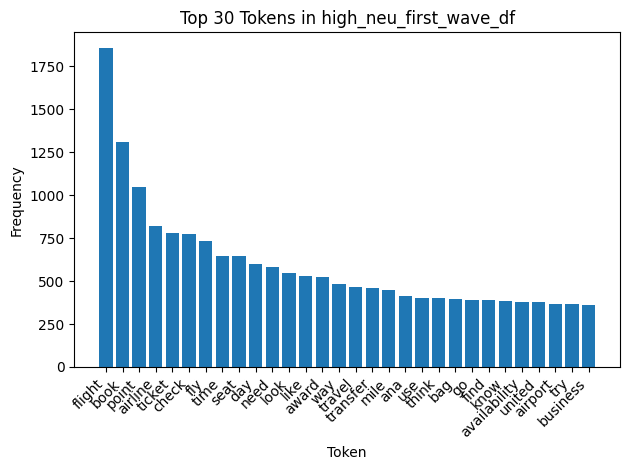

In [28]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [29]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


87645 words total, with a vocabulary size of 7612
Max reddit post length is 204 tokens
Mean reddit post length is 11.32 tokens
Median reddit post length is 8 tokens


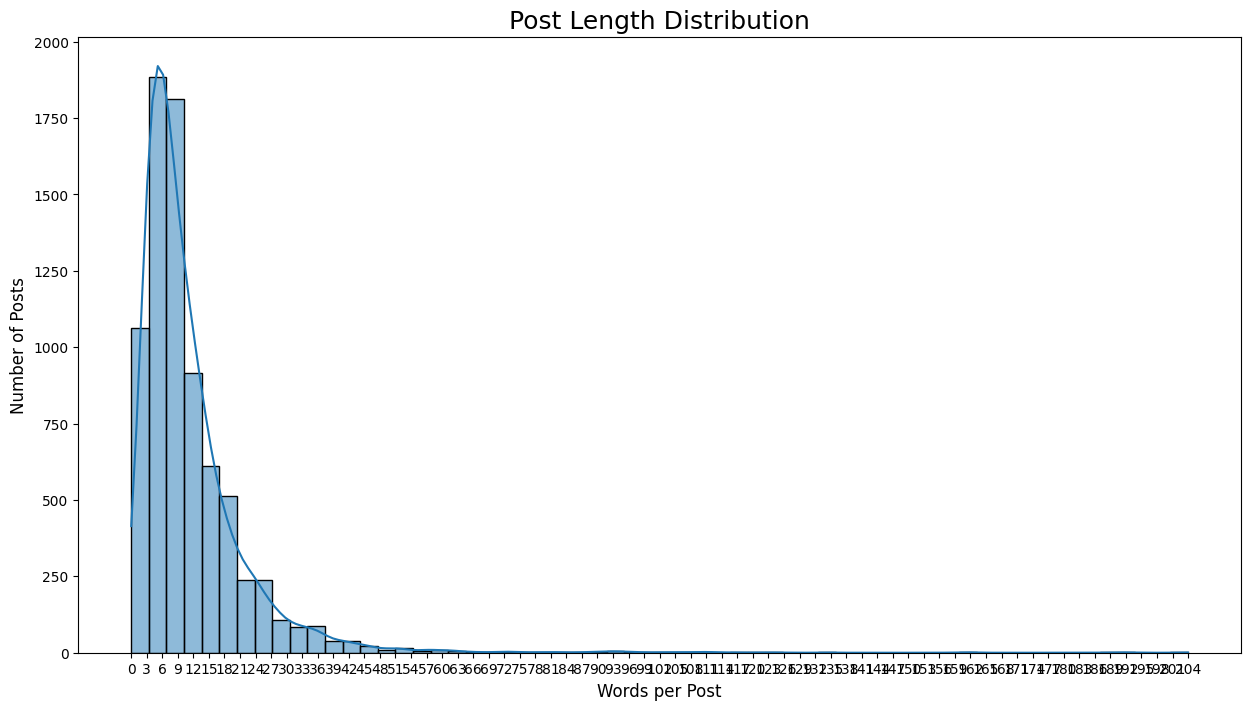

In [30]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

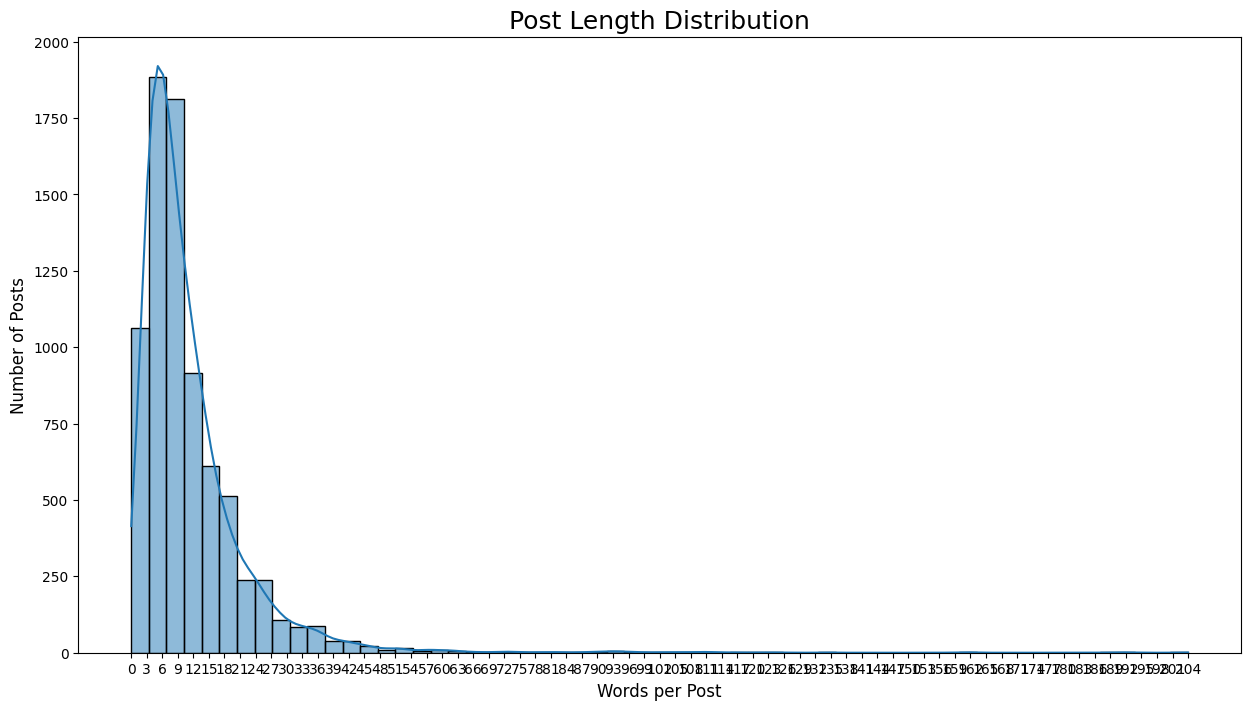

In [31]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [32]:
!pip install gensim

In [33]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
63021                   [transfer, hyatt, read, sidebar]   
63028  [see, thing, guess, availability, christmas, h...   
63030  [think, registration, close, want, search, fly...   
63033  [question, fee, qatar, flight, availability, s...   
63035  [emirate, ewr, ath, point, usd, read, potentia...   

                                           bigram_tokens  \
63021                    [transfer, hyatt, read_sidebar]   
63028  [see, thing, guess, availability, christmas, h...   
63030  [think, registration, close, want, search, fly...   
63033  [question, fee, qatar, flight, availability, s...   
63035  [emirate, ewr, ath, point, usd, read, potentia...   

                                          trigram_tokens  
63021                    [transfer, hyatt, read_sidebar]  
63028  [see, thing, guess, availability, christmas, h...  
63030  [think, registration, close, want, search, fly...  
63033  [question, fee, qatar, flight, avai

In [34]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   1824
Rows with trigrams:  16
Rows with no n-grams: 5919


In [35]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
63021,2023-01-02,high neu,0.875133,transfer hyatt read sidebar,"[transfer, hyatt, read, sidebar]",transfer hyatt read sidebar,"[transfer, hyatt, read_sidebar]","[transfer, hyatt, read_sidebar]",True,False
63028,2023-01-02,high neu,0.750716,op seeing thing guess availability around chri...,"[see, thing, guess, availability, christmas, h...",see thing guess availability christmas hopeful...,"[see, thing, guess, availability, christmas, h...","[see, thing, guess, availability, christmas, h...",False,False
63030,2023-01-02,high neu,0.777701,think registration still closed may want searc...,"[think, registration, close, want, search, fly...",think registration close want search flyertalk...,"[think, registration, close, want, search, fly...","[think, registration, close, want, search, fly...",False,False
63033,2023-01-02,high neu,0.867598,question see fee qatar aa flight show availabi...,"[question, fee, qatar, flight, availability, s...",question fee qatar flight availability similar...,"[question, fee, qatar, flight, availability, s...","[question, fee, qatar, flight, availability, s...",True,False
63035,2023-01-02,high neu,0.867361,emirate ewr ath point usd reading potential de...,"[emirate, ewr, ath, point, usd, read, potentia...",emirate ewr ath point usd read potential deval...,"[emirate, ewr, ath, point, usd, read, potentia...","[emirate, ewr_ath, point, usd, read, potential...",False,False


In [36]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 7743
Number of rows in 'trigram_tokenized' column: 7743


In [37]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 6

Most common trigrams:
star_alliance_partner: 9
psa_texas_division: 4
round_trip_oneway: 3
hard_rock_royalty: 3
fine_jane_doe: 3
jane_doe_deer: 2


In [38]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [39]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=100,
#                                         iterations=50,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [40]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [41]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
63021,2023-01-02,high neu,0.875133,transfer hyatt read sidebar,"[transfer, hyatt, read, sidebar]",transfer hyatt read sidebar,"[transfer, hyatt, read_sidebar]","[transfer, hyatt, read_sidebar]",True,False
63028,2023-01-02,high neu,0.750716,op seeing thing guess availability around chri...,"[see, thing, guess, availability, christmas, h...",see thing guess availability christmas hopeful...,"[see, thing, guess, availability, christmas, h...","[see, thing, guess, availability, christmas, h...",False,False
63030,2023-01-02,high neu,0.777701,think registration still closed may want searc...,"[think, registration, close, want, search, fly...",think registration close want search flyertalk...,"[think, registration, close, want, search, fly...","[think, registration, close, want, search, fly...",False,False
63033,2023-01-02,high neu,0.867598,question see fee qatar aa flight show availabi...,"[question, fee, qatar, flight, availability, s...",question fee qatar flight availability similar...,"[question, fee, qatar, flight, availability, s...","[question, fee, qatar, flight, availability, s...",True,False
63035,2023-01-02,high neu,0.867361,emirate ewr ath point usd reading potential de...,"[emirate, ewr, ath, point, usd, read, potentia...",emirate ewr ath point usd read potential deval...,"[emirate, ewr, ath, point, usd, read, potentia...","[emirate, ewr_ath, point, usd, read, potential...",False,False


In [42]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [43]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [44]:
## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50, 100,200]
iterations_range = [50,  100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha, eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.4239, Coherence: 0.4760, Alpha: [0.5912044 3.0601523], Eta: [ 0.7538966   0.4196736  15.966107   ...  0.29632676  0.2963052
  0.286208  ]
Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.4243, Coherence: 0.4552, Alpha: [0.59895587 3.0493717 ], Eta: [ 0.7529413   0.42078626 15.836196   ...  0.2961281   0.2960569
  0.28599384]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.4242, Coherence: 0.4552, Alpha: [0.5981399 3.0429008], Eta: [ 0.75291634  0.41857845 15.877702   ...  0.29613557  0.296069
  0.28601083]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.3852, Coherence: 0.4840, Alpha: [0.45000738 2.587979  ], Eta: [ 0.811819    0.4467124  17.940586   ...  0.31282812  0.31269333
  0.29598516]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.3853, Coherence: 0.4840, Alpha: [0.45038563 2.5903988 ], Eta: [ 0.81279206  0.4469807  17.542301   ...  0.31289524  0.31269532
  0.2959682 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.3852, Coherence: 0.4840, Alpha: [0.4500638 2.5856085], Eta: [ 0.8120895   0.44679657 17.926249   ...  0.31287736  0.31267625
  0.29599833]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.3494, Coherence: 0.5459, Alpha: [0.24675098 1.8227315 ], Eta: [ 0.8802988   0.47596335 21.07748    ...  0.33706915  0.33446237
  0.31150237]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.3494, Coherence: 0.5459, Alpha: [0.24516033 1.8151611 ], Eta: [ 0.8808125   0.47578248 21.029844   ...  0.33719632  0.33445814
  0.3115751 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.3495, Coherence: 0.5459, Alpha: [0.24615136 1.8191582 ], Eta: [ 0.8802705   0.47568604 21.074224   ...  0.33708173  0.33435988
  0.3114859 ]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.4813, Coherence: 0.4735, Alpha: [1.225056  2.1783667 1.6077268], Eta: [0.324783   0.25186524 0.40719387 ... 0.21923596 0.21400453 0.22014877]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.4840, Coherence: 0.4956, Alpha: [1.501448  2.1119237 1.6223359], Eta: [0.32359517 0.25191906 0.40485728 ... 0.21947467 0.21341456 0.21972129]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.4758, Coherence: 0.5192, Alpha: [1.7408681 1.9782996 1.3102492], Eta: [0.32381085 0.25161493 0.4020659  ... 0.21961533 0.2137618  0.21965279]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.4343, Coherence: 0.4682, Alpha: [1.0121496 1.9456315 1.393

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.4227, Coherence: 0.3992, Alpha: [2.7616127  0.41979265], Eta: [0.8186287  0.41660407 1.2701592  ... 0.2965884  0.30021575 0.28723538]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.4225, Coherence: 0.3984, Alpha: [2.7187798  0.41439292], Eta: [0.81805885 0.41624764 1.2644502  ... 0.2965336  0.30018574 0.2870658 ]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.4225, Coherence: 0.3984, Alpha: [2.7164545  0.41388667], Eta: [0.8180711  0.41620338 1.2643273  ... 0.29651728 0.30016953 0.28703246]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.3813, Coherence: 0.4229, Alpha: [2.0177047  0.26508775], Eta: [0.8936325  0.44812727 1.3641554  ... 0.31193802 0.31920606 0.29933473]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.3813, Coherence: 0.4229, Alpha: [1.9987888 0.2715851], Eta: [0.89305985 0.4464893  1.347837   ... 0.3109102  0.31858632 0.2988277 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.3813, Coherence: 0.4229, Alpha: [2.002214   0.27210277], Eta: [0.8931124  0.44647706 1.3476819  ... 0.31090927 0.31858316 0.2988282 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.3507, Coherence: 0.4299, Alpha: [1.7531357  0.23000857], Eta: [0.95278174 0.46923292 1.4207922  ... 0.3233574  0.33766052 0.31148475]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.3511, Coherence: 0.4275, Alpha: [1.7687684  0.24117093], Eta: [0.9503628  0.46659178 1.4051445  ... 0.32189342 0.33675793 0.3106155 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.3511, Coherence: 0.4299, Alpha: [1.7676809  0.24067354], Eta: [0.9518576  0.46672457 1.4059128  ... 0.3219757  0.33678007 0.3106541 ]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.4998, Coherence: 0.3800, Alpha: [4.3757296  1.5268065  0.64856946], Eta: [0.35240006 0.26914227 0.42497835 ... 0.22407275 0.22582455 0.23081122]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.5033, Coherence: 0.3677, Alpha: [4.7248316  1.5862501  0.67699283], Eta: [0.35376108 0.270475   0.42602178 ... 0.22593011 0.22627267 0.23131192]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.5050, Coherence: 0.3877, Alpha: [4.7519097  1.6757314  0.71784055], Eta: [0.3528221  0.2697104  0.42500275 ... 0.22536257 0.22619194 0.2305442 ]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.4552, Coherence: 0.3818, Alpha: [3.9002385  1.3255485  0

Num Topics: 9, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.7327, Coherence: 0.3659, Alpha: [3.1879086  1.7475265  0.90406483 1.0672537  4.555775   0.9476954
 1.1582501  0.9787181  0.6085107 ], Eta: [0.10172226 0.09848219 0.10323705 ... 0.09150539 0.09097426 0.09153638]
Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.3994, Coherence: 0.4926, Alpha: [1.6274037 0.52906  ], Eta: [1.0119885  0.39465827 1.2610366  ... 0.2800557  0.29350808 0.28561068]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.3996, Coherence: 0.4926, Alpha: [1.6356182  0.52076393], Eta: [0.9857184  0.39492804 1.265085   ... 0.2801699  0.2936922  0.28582716]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.3996, Coherence: 0.4926, Alpha: [1.6349893 0.5188009], Eta: [0.9836601  0.39492503 1.265347   ... 0.28017464 0.2937089  0.2858419 ]
Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.3528, Coherence: 0.5503, Alpha: [1.1017097  0.27505827], Eta: [1.3543111  0.4206378  1.3862102  ... 0.29606193 0.31532505 0.30319247]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -7.3530, Coherence: 0.5503, Alpha: [1.1064733 0.2757582], Eta: [1.3331535  0.4207307  1.3887776  ... 0.29610178 0.31535512 0.30327085]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -7.3529, Coherence: 0.5503, Alpha: [1.1040902  0.27475715], Eta: [1.3359814  0.4207888  1.3895737  ... 0.29613203 0.3153965  0.30331245]
Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -7.3146, Coherence: 0.5359, Alpha: [0.77391046 0.17840438], Eta: [1.1735175  0.4412317  1.5102067  ... 0.3150312  0.31505224 0.3225846 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -7.3151, Coherence: 0.5346, Alpha: [0.78558004 0.18193135], Eta: [1.2326478  0.4408492  1.5093073  ... 0.3148173  0.31484282 0.32214773]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -7.3152, Coherence: 0.5346, Alpha: [0.785761  0.1819288], Eta: [1.2281405  0.4408564  1.5090154  ... 0.3148213  0.31484678 0.3221642 ]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -7.5169, Coherence: 0.3585, Alpha: [3.9746492 1.0958976 2.8581772], Eta: [0.33925667 0.26777935 0.42747954 ... 0.22323228 0.22354437 0.22040895]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -7.5306, Coherence: 0.4106, Alpha: [3.6997626 1.5574913 3.8725684], Eta: [0.33849943 0.26337388 0.4182368  ... 0.22103894 0.22178164 0.22143419]
Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -7.5281, Coherence: 0.3968, Alpha: [2.9716868 1.5416639 4.116329 ], Eta: [0.3420236  0.26398376 0.4206488  ... 0.22085223 0.22182737 0.2208872 ]
Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -7.4704, Coherence: 0.3424, Alpha: [3.4669073  0.87302047 2.5038426 ],

In [45]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5519
 Perplexity: -7.3983
 Alpha (per topic): [1.4359884 1.5487597 0.9157128]
 Eta   (per word):  [0.33469817 0.25990632 0.4062621  ... 0.22503239 0.22654575 0.2306275 ]


In [46]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [48]:
# Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.036*"book" + 0.023*"point" + 0.015*"look" + 0.012*"use" + 0.011*"united" '
  '+ 0.011*"award" + 0.011*"find" + 0.010*"pay" + 0.010*"transfer" + '
  '0.010*"way"'),
 (1,
  '0.058*"flight" + 0.028*"airline" + 0.021*"time" + 0.020*"fly" + 0.016*"day" '
  '+ 0.015*"seat" + 0.014*"airport" + 0.012*"hour" + 0.010*"think" + '
  '0.009*"go"'),
 (2,
  '0.035*"check" + 0.034*"ticket" + 0.026*"need" + 0.023*"bag" + '
  '0.013*"change" + 0.012*"sure" + 0.011*"ask" + 0.011*"gate" + 0.010*"yes" + '
  '0.008*"passport"')]

Sample doc-topic distribution for doc 0:
[(0, 0.64187944), (1, 0.22505312), (2, 0.13306744)]


In [49]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [50]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  book (0.0357)
  point (0.0230)
  look (0.0152)
  use (0.0122)
  united (0.0107)
  award (0.0106)
  find (0.0105)
  pay (0.0102)
  transfer (0.0099)
  way (0.0098)
  like (0.0098)
  want (0.0096)
  year (0.0093)
  get (0.0089)
  mile (0.0089)
  ana (0.0088)
  delta (0.0083)
  price (0.0083)
  date (0.0080)
  availability (0.0077)
  option (0.0075)
  booking (0.0074)
  trip (0.0072)
  buy (0.0072)
  available (0.0071)
  partner (0.0068)
  know (0.0067)
  night (0.0065)
  depend (0.0065)
  right (0.0062)

Topic 2:
  flight (0.0576)
  airline (0.0278)
  time (0.0205)
  fly (0.0199)
  day (0.0158)
  seat (0.0150)
  airport (0.0140)
  hour (0.0116)
  think (0.0103)
  go (0.0092)
  try (0.0089)
  travel (0.0072)
  different (0.0071)
  terminal (0.0069)
  long (0.0069)
  route (0.0067)
  able (0.0061)
  week (0.0060)
  website (0.0057)
  layover (0.0056)
  international (0.0053)
  know (0.0052)
  leave (0.0049)
  maybe (0.0047)
  people (0.0047)
  con

In [51]:
lda_opt.save('/content/drive/MyDrive/lda_model_neu_4th_wave_normal.gensim')

In [52]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
id2word.filter_extremes(no_below=5, no_above=0.7)

#    (Optional) Re-map the remaining token IDs to remove gaps
id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1)]


In [53]:
## FIND THE OPTIMAL TOPIC

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools



# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
      # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [50, 100,200]
iterations_range = [50,  100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha, eta))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.6906, Coherence: 0.5575, Alpha: [1.3180525 1.4352404], Eta: [0.50442517 0.2759401  0.68191445 ... 0.2661666  0.36065483 0.32226765]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.6906, Coherence: 0.5575, Alpha: [1.3065882 1.4401597], Eta: [0.50440836 0.2756455  0.68264747 ... 0.2660162  0.36571783 0.3209395 ]


Num Topics: 2, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.6906, Coherence: 0.5575, Alpha: [1.300909  1.4468334], Eta: [0.50560176 0.27560398 0.6823853  ... 0.26600885 0.365589   0.3204429 ]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.6630, Coherence: 0.5437, Alpha: [1.1252208 1.3955362], Eta: [0.6144457  0.2892559  0.7032752  ... 0.27452683 0.35201162 0.31740987]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.6630, Coherence: 0.5391, Alpha: [1.1207273 1.3928572], Eta: [0.6215495  0.28929225 0.70424134 ... 0.27454242 0.3533456  0.31738445]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.6630, Coherence: 0.5391, Alpha: [1.1180599 1.3964593], Eta: [0.62698543 0.28921688 0.7038693  ... 0.2745222  0.3531722  0.31728822]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.6438, Coherence: 0.5028, Alpha: [1.0094718 1.349362 ], Eta: [0.6757347  0.29973724 0.7294543  ... 0.28431123 0.35398415 0.3236311 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.6439, Coherence: 0.4992, Alpha: [1.004894  1.3479835], Eta: [0.7050653  0.29967925 0.73030823 ... 0.28426093 0.35560167 0.3236996 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.6439, Coherence: 0.4992, Alpha: [1.0044961 1.3496997], Eta: [0.70313746 0.2996697  0.7301094  ... 0.28425127 0.3552403  0.32367325]


Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.7431, Coherence: 0.5281, Alpha: [2.5010278 3.0935323 2.0886574], Eta: [0.23939008 0.20311119 0.28304383 ... 0.19987139 0.21638842 0.20527513]


Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.7391, Coherence: 0.5315, Alpha: [2.314281  2.7067513 2.1465824], Eta: [0.24268155 0.20786856 0.27752122 ... 0.19958724 0.21206434 0.21174584]


Num Topics: 3, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.7390, Coherence: 0.5092, Alpha: [2.5009751 2.7491817 2.3346121], Eta: [0.23657985 0.20922703 0.2709722  ... 0.20087601 0.22113419 0.20765041]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.7144, Coherence: 0.5191, Alpha: [2.3812728 3.0250688 2.0659196], Eta: [0.24451678 0.20608576 0.28791934 ... 0.1963862  0.20937791 0.20252432]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.7106, Coherence: 0.5079, Alpha: [2.2607598 2.684158  2.1340282], Eta: [0.24782841 0.2104285  0.27910015 ... 0.19652209 0.20608291 0.20748858]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.7114, Coherence: 0.5243, Alpha: [2.4271934 2.7109308 2.3187497], Eta: [0.24088302 0.21098787 0.2724501  ... 0.19695301 0.21216506 0.2049637 ]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.6943, Coherence: 0.4801, Alpha: [2.3356705 3.0155034 2.0804179], Eta: [0.24786216 0.2077726  0.29036242 ... 0.1955639  0.20592248 0.2026004 ]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.6888, Coherence: 0.4865, Alpha: [2.1633203 2.6354542 2.0809462], Eta: [0.25259465 0.21167006 0.27973768 ... 0.1958485  0.20328279 0.20692323]
Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.6901, Coherence: 0.4876, Alpha: [2.361919  2.5948873 2.268331 ], Eta: [0.24400689 0.21308999 0.27326176 ... 0.19578445 0.20770349 0.20939529]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 50, Perplexity: -6.7754, Coherence: 0.4551, Alpha: [2.9463124 3.9064522 2.4414177 4.1139174], Eta: [0.17563447 0.15652002 0.18809354 ... 0.15869975 0.17452405 0.16223414]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 100, Perplexity: -6.7764, Coherence: 0.4512, Alpha: [2.7702155 3.5062585 2.5260231 5.114208 ], Eta: [0.17562382 0.15651953 0.18873288 ... 0.16320948 0.17266482 0.16272624]
Num Topics: 4, Chunksize: 250, Passes: 50, Iterations: 200, Perplexity: -6.7717, Coherence: 0.4384, Alpha: [2.7

In [54]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5575
 Perplexity: -6.6906
 Alpha (per topic): [1.3180525 1.4352404]
 Eta   (per word):  [0.50442517 0.2759401  0.68191445 ... 0.2661666  0.36065483 0.32226765]


In [55]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [57]:
# Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.026*"check" + 0.018*"bag" + 0.018*"need" + 0.015*"time" + 0.015*"airport" '
  '+ 0.012*"hour" + 0.008*"change" + 0.008*"sure" + 0.008*"gate" + '
  '0.008*"know"'),
 (1,
  '0.059*"flight" + 0.028*"airline" + 0.027*"book" + 0.019*"fly" + '
  '0.019*"ticket" + 0.015*"day" + 0.014*"point" + 0.013*"seat" + 0.012*"like" '
  '+ 0.011*"look"')]

Sample doc-topic distribution for doc 0:
[(0, 0.41043192), (1, 0.5895681)]


In [58]:
#  pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [59]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  check (0.0257)
  bag (0.0179)
  need (0.0178)
  time (0.0148)
  airport (0.0148)
  hour (0.0119)
  change (0.0084)
  sure (0.0082)
  gate (0.0080)
  know (0.0078)
  terminal (0.0075)
  ask (0.0074)
  yes (0.0072)
  long (0.0069)
  passport (0.0068)
  security (0.0061)
  ticket (0.0054)
  thing (0.0052)
  allow (0.0051)
  international (0.0051)
  luggage (0.0051)
  number (0.0049)
  travel (0.0049)
  country (0.0045)
  custom (0.0045)
  domestic (0.0045)
  immigration (0.0044)
  free (0.0044)
  rule (0.0043)
  case (0.0043)

Topic 2:
  flight (0.0592)
  airline (0.0275)
  book (0.0266)
  fly (0.0195)
  ticket (0.0192)
  day (0.0149)
  point (0.0136)
  seat (0.0130)
  like (0.0119)
  look (0.0112)
  way (0.0107)
  use (0.0088)
  united (0.0079)
  try (0.0078)
  find (0.0076)
  go (0.0075)
  price (0.0071)
  transfer (0.0067)
  travel (0.0067)
  delta (0.0065)
  option (0.0060)
  year (0.0059)
  layover (0.0059)
  date (0.0058)
  award (0.0058)
 

In [60]:
lda_opt.save('/content/drive/MyDrive/lda_model_neu_4th_wave_pruned.gensim')

In [61]:
# # Visualization (Optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Coherence vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='coherence', hue='chunksize', marker='o')
# plt.title('Coherence Score vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.legend(title='Chunksize')
# plt.show()

# # Perplexity vs. Number of Topics
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='num_topics', y='perplexity', hue='chunksize', marker='o')
# plt.title('Perplexity vs Number of Topics')
# plt.xlabel('Number of Topics')
# plt.ylabel('Perplexity')
# plt.legend(title='Chunksize')
# plt.show()

# # Coherence vs. Perplexity (Trade-off)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='perplexity', y='coherence', hue='num_topics', style='chunksize', s=100)
# plt.title('Coherence vs Perplexity')
# plt.xlabel('Perplexity')
# plt.ylabel('Coherence Score')
# plt.legend(title='Num Topics')
# plt.show()


In [62]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()